# Anomaly Detection and Recommender Systems

Stanford CS229 - Machine Learning by Andrew Ng. Programming exercise 8.

Please check out [the repository on GitHub](https://github.com/rickwierenga/CS229-Python/). If you spot any mistakes or inconcistencies, please create an issue. For questions you can find me on Twitter: [@rickwierenga](https://twitter.com/rickwierenga). Starring the project on GitHub means a ton to me!

In [31]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io as sio
from scipy.optimize import minimize
%matplotlib inline

## Anomaly detection

$x \in \mathbb(R)$ is a distributed Gaussian with mean $\mu$ and variance $\sigma$.

$x \sim \mathcal{N}(\mu, \sigma^2)$ ($\sim$: distributed as)

We fit the parameters

$\mu = \frac{1}{m}\displaystyle\sum_{i = 1}^{m}x^{(i)}$, $\sigma = \frac{1}{m}\displaystyle\sum_{i = 1}^m(x^{(i)} - \mu)$.

Then we use the following function:

$$p(x;\mu, \sigma^2) = \displaystyle\prod_{j = 1}^{n}p(x_j; \mu_j, \sigma^2)$$

Anomaly if $p(x) < \epsilon$.

### Algorithm
1. Choose features $x_j$.
2. Fit parameters $\mu_1, ..., \sigma_n$, $\mu_1, ..., \sigma_n$.
3. Given new example $x$, compute $p(x)$.

### Anomaly Detection vs Supervised Learning
Use *anomaly detection*:
* Very small number of positive examples ($y = 1$).
* Many different "types" of anomaly.
* Future anomalies may look nothing like any of the anomalous examples we've seen so far.

Use *supervised learning*:
* Large number of positive and negative examples.
* Enough positive examples for the algorithm to get a sense of what positive examples look like.
* Future examples look like examples from the dataset.

### Tips
* Examine the examples the model got wrong by hand and try to come up with new features. 
* Have a look at the distribution. If it doesn't look like a bell curve, apply log or square root function to each traning example.

### Multivariate Gaussian Distribution
![mgd](images/mgd.png)

Instead of modelling $p(x_1), p(x_2), ...$ seperately, we model $p(x)$ in one go. Parameters $\mu \in \mathbb{R}^n$, $\Sigma \in \mathbb{R}^{n \times n}.$

#### Original vs Multivariate
With the original model you have to manually create featuers to capture anomalies where $x_1$, $x_2$ take unusual combinations of values where the multivariate model automatically captures the correlations. The original model is computationaly cheaper and works OK when $m$ is small (the multivariate model must have $m > n$.

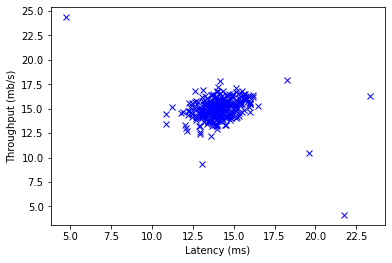

In [32]:
data = sio.loadmat('ex8data1.mat')
X = data["X"]
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

**Exercise**: Complete the `estimate_gaussian` function to return an n-dimensional vector $\mu$ that holds the mean for every feature and a vector $\sigma^2$ that holds the variance.

In [33]:
def estimate_gaussian(X):
    m = X.shape[0]
    mu = np.mean(X, axis = 0)
    squared_sigma = (1/m) * sum((X-mu)**2)
    return mu, squared_sigma

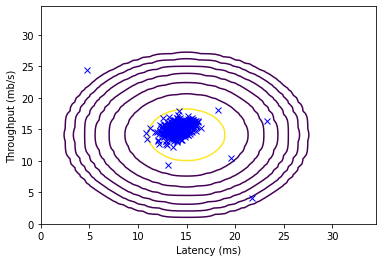

In [34]:
from scipy.stats import multivariate_normal
mu, sigma2 = estimate_gaussian(X)

# Create the grid for plotting
X1, X2 = np.meshgrid(np.arange(0, 35, 0.5), np.arange(0, 35, 0.5))
grid = np.vstack((X2.flatten(), X1.flatten())).T

Z = multivariate_normal.pdf(x=grid, mean=mu, cov=sigma2)
Z = Z.reshape(X1.shape)

plt.contour(X1, X2, Z, np.array([10.]) ** np.arange(-21, 0, 3.))
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### The $F_1$ score and choosing $\epsilon$
Remember:
$$prec = \frac{tp}{tp + fp}$$
$$rec = \frac{tp}{tp+fn}$$

* $tp$ is true positive
* $tp$ is false positive
* $tp$ is false negative
* $precision$ is precision
* $recall$ is false negative

$$F_1 = \frac{2 * prec * rec}{prec + rec}$$

For this dataset we use the $F_1$ score to measure the accuracy because there are very few negative traning examples.

**Exercise**: Write a method the compute the $F_1$ score and select the best $\epsilon$.

In [35]:
def select_threshold(ycv, pcv):
    f1 = 0
    best_f1 = 0
    best_epsilon = 0
    step_size = (max(pcv) - min(pcv)) / 1000
    for epsilon in np.arange(min(pcv),max(pcv), step_size):
        predictions = pcv < epsilon
        true_pos = np.sum(np.logical_and(predictions == 1, ycv == 1))
        false_pos = np.sum(np.logical_and(predictions == 1, ycv == 0))
        false_neg = np.sum(np.logical_and(predictions == 0, ycv == 1))
        
        if (true_pos + false_neg) == 0:
            continue
            
        precision = true_pos/(true_pos + false_pos)
        recall = true_pos/(true_pos + false_neg)
        f1 = (2 * precision * recall)/(precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    return best_epsilon, best_f1

You should find the best $F_1$ score for $\epsilon \approx 8.99\cdot10^{-05}$ and $F_1 = 0.875$. 

In [36]:
Xcv = data["Xval"]
ycv = data["yval"].flatten()
pcv = multivariate_normal.pdf(x=Xcv, mean=mu, cov=sigma2)
select_threshold(ycv, pcv)

<ipython-input-35-544058b9ac5f>:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos/(true_pos + false_pos)


(8.990852779269496e-05, 0.8750000000000001)

### Multidimensional Outliers

If you completed the exercises above correctly, the code should return $\epsilon \approx 1.38\cdot10^{-18}$ and $F_1 \approx 0.615385$.

In [37]:
# Load data
data = sio.loadmat('ex8data2.mat')
X = data["X"]
Xcv = data["Xval"]
ycv = data["yval"].flatten()

# Fit mu and sigma
mu, sigma2 = estimate_gaussian(X)

# Choose epsilon
pcv = multivariate_normal.pdf(x=Xcv, mean=mu, cov=sigma2)
select_threshold(ycv, pcv)

<ipython-input-35-544058b9ac5f>:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos/(true_pos + false_pos)


(1.3772288907613604e-18, 0.6153846153846154)

## Recommender systems
### Problem formulation
$r(i,j) = 1$ if user $j$ has rated movie $i$

$y^{(i,j)}$ = rating by user $j$ on movie $i$

$\theta(j)$ = parameter vector for user $j$

$x^{(i)}$ = feature vector for movie $i$

For user $j$, movie $i$, predict rating $(\theta^{(j)})^T(x^{(i)})$

$m^{(j)}$ = no. of movies rated by user $j$

Learn $\theta^{(j)}$:
$$\min_{\theta^{(1)}, ..., \theta^{(j)}}
\frac{1}{2}\displaystyle\sum_{j = 1}^{n_u}\displaystyle\sum_{i:r(i,j)=1}\left((\theta^{(j)})^Tx^{(i)} - y^{(i, j)}\right)^2+\frac{\lambda}{2}\displaystyle\sum_{j = 1}^{n_u}\displaystyle\sum_{k = 1}^{n}(\theta_k^{(j)})^2$$

### Collaborative filtering
Given $x^{(1)},...,x^{(n_m)}$ we can estimate $\theta^{(1)},...,\theta^{(n_m)}$. Given $\theta^{(1)},...,\theta^{(n_m)}$, we can estimate $x^{(1)},...,x^{(n_m)}$. 

Guess $\theta \rightarrow x \rightarrow \theta \rightarrow x \rightarrow\ ...$

#### Collaborative filtering algorithm

We want to minimize $\theta^{(1)},...,\theta^{(n_m)}$ and $x^{(1)},...,x^{(n_m)}$ simultaniously:

$$\min_{\theta^{(1)}, ..., \theta^{(n_m)} \\ x^{(1)}, ..., x^{(n_u)}}
\frac{1}{2}\displaystyle\sum_{j = 1}^{n_u}\displaystyle\sum_{i:r(i,j)=1}\left((\theta^{(j)})^Tx^{(i)} - y^{(i, j)}\right)^2+\frac{\lambda}{2}\displaystyle\sum_{i = 1}^{n_m}\displaystyle\sum_{k = 1}^{n}(x_k^{(j)})^2+\frac{\lambda}{2}\displaystyle\sum_{j = 1}^{n_u}\displaystyle\sum_{k = 1}^{n}(\theta_k^{(j)})^2$$

1. We start by randomly initializing $\theta^{(1)}, ..., \theta^{(n_m)}$, $x^{(1)}, ..., x^{(n_u)}$ with small random values (symmetry breaking).
2. Minimize cost function.
3. For a user with parameters $\theta$ and a movie with learned featurs $x$, predict a star rating of $\theta^Tx$.

#### Low rank matrix factorization
We can take $Y$ as the matrix of all ratings. We can get the predicted ratings in a vectorized fashion using $X$ and $\Theta$ by $X\Theta^T$.

You can find related movies $j$ to movie $i$ by finding movies with a small value for $||x^{(i)} - x^{(j)}||$.

#### Mean normalization
We substract matrix $\mu$ with the average ratings for each movie from $Y$. Then for user $j$ on movie $i$ predict $(\theta^{(j)})^T(x^{(i)})+\mu_i$

In [38]:
def normalize_ratings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros_like(Y)
    print(1, Ymean.shape)
    Ymean = np.mean(Y, axis=0)
    print(2, Ymean.shape)
    
    return Ymean, Ynorm

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.2 This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

The matrix $Y$ (a num movies $\times$ num users matrix) stores the ratings $y(^{i,j)})$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.


### Loading the data

In [39]:
data = sio.loadmat('ex8_movies.mat')
Y = data["Y"]
R = data["R"]
Y.shape, R.shape

((1682, 943), (1682, 943))

In [40]:
'Average rating for movie 1: {}'.format(np.mean(Y[0, R[0, :]]))

'Average rating for movie 1: 4.52067868504772'

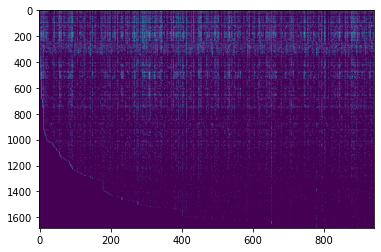

In [41]:
plt.imshow(Y, aspect='auto')

### Collaborative filtering learning algorithm

**Exercise**: Implement collaborative filtering cost function.

In [66]:
def cofi_cost(params, Y, R, num_users, num_movies, num_features, _lambda):
    """
    Collaborative filtering cost function
    """
    
    # unpack values
    X = params[:num_movies*num_features].reshape((num_movies, num_features))
    Theta = params[num_movies*num_features:].reshape((num_users, num_features))
    
    regularization = (_lambda/2)*np.sum(Theta**2) + (_lambda/2)*np.sum(X**2)
    J = np.sum(((X@Theta.T)*R - Y)**2)/2 + regularization
    
    return J

In [91]:
def cofi_gradient(params, Y, R, num_users, num_movies, num_features, _lambda):
    X = params[:num_movies*num_features].reshape((num_movies, num_features))
    Theta = params[num_movies*num_features:].reshape((num_users, num_features))
    
    Theta_grad = ((X@Theta.T)*R - Y).T@X + _lambda* Theta
    X_grad = ((X@Theta.T)*R - Y)@Theta + _lambda * X
    
    grad = np.hstack((X_grad.flatten(), Theta_grad.flatten()))
    return grad

We'll load pre-trained weights to examine the cost function.

In [76]:
data = sio.loadmat('ex8_movieParams.mat')
Theta = data["Theta"]
X = data["X"]

# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X_ = X[:num_movies, :num_features]
Theta_ = Theta[:num_users, :num_features]
Y_ = Y[:num_movies, :num_users]
R_ = R[:num_movies, :num_users]

The following should return approximately $22.22$.

In [77]:
J = cofi_cost(np.hstack((X_.flatten(),  Theta_.flatten())), Y_, R_, num_users, num_movies, num_features, 0)
           
'Cost at loaded parameters: {}'.format(J)

'Cost at loaded parameters: 22.224603725685675'

The following should return approximately $31.34$.

In [78]:
J = cofi_cost(np.hstack((X_.flatten(),  Theta_.flatten())), Y_, R_, num_users, num_movies, num_features, 1.5)
           
'Cost at loaded parameters: {}'.format(J)

'Cost at loaded parameters: 31.34405624427422'

### Training the model

In [79]:
from load_movie_list import load_movie_list
movie_list = load_movie_list()
movie_list[0]

'Toy Story (1995)\n'

In [80]:
# Initialize new user ratings
new_ratings = np.zeros((1682, 1))

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
new_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
new_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
new_ratings[6] = 3
new_ratings[11]= 5
new_ratings[53] = 4
new_ratings[63]= 5
new_ratings[65]= 3
new_ratings[68] = 5
new_ratings[182] = 4
new_ratings[225] = 5
new_ratings[354]= 5

for i in range(len(new_ratings)):
    rating = new_ratings[i]
    if rating > 0:
        print("Rated {} for {}".format(int(rating), movie_list[i]), end='')

Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


In [81]:
# Add new ratings to dataset
Y = np.hstack((new_ratings, Y))
R = np.hstack((new_ratings != 0, R))

In [92]:
from scipy.optimize import fmin_cg

# Perform normalization
Ymean, Ynorm = normalize_ratings(Y, R)

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
print('num_users: ', num_users,' num_movies : ', num_movies,' num_features : ', num_features)

# Set initial parameters
print("Set initial parameters")
X = np.random.random((num_movies, num_features))
Theta = np.random.random((num_users, num_features))
initial_parameters = np.hstack((X.flatten(),  Theta.flatten()))

# Train
print("Train")
_lambda = 10
results = fmin_cg(cofi_cost, initial_parameters, args = (Y, R, num_users, num_movies, num_features, _lambda),
                  fprime = cofi_gradient)

# Extract results
print("Extract results")
print(results)
params = results
X = params[:num_movies*num_features].reshape((num_movies, num_features))
Theta = params[num_movies*num_features:].reshape((num_users, num_features))

p = X @ Theta.T
predictions = p[0, :] + Ymean
print(predictions.shape, Ymean.shape)
for i, prediction in enumerate(list(sorted(predictions, reverse=True))[:10]):
    if prediction > 0:
        print("Rated {} for {}".format(prediction, movie_list[i]), end='')

1 (1682,)
2 (944,)
num_users:  944  num_movies :  1682  num_features :  10
Set initial parameters
Train
         Current function value: 71900.766218
         Iterations: 1867
         Function evaluations: 2826
         Gradient evaluations: 2826
Extract results
[0.19490918 0.52575353 0.23009744 ... 0.94838582 0.33249604 0.19911041]
(944,) (944,)
Rated 5.839065801100059 for Toy Story (1995)
Rated 5.817968801024612 for GoldenEye (1995)
Rated 5.713561968384961 for Four Rooms (1995)
Rated 5.707068155601141 for Get Shorty (1995)
Rated 5.6649774409786895 for Copycat (1995)
Rated 5.633939276661824 for Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Rated 5.6096233931524315 for Twelve Monkeys (1995)
Rated 5.570647621944991 for Babe (1995)
Rated 5.531598784916152 for Dead Man Walking (1995)
Rated 5.455543203104204 for Richard III (1995)
